# Klasifikace obrázků CIFAR-10 pomocí konvoluční sítě

Úkolem cvičení je natrénovat konvoluční síť pro klasifikaci na datasetu CIFAR-10 s alespoň 75% úpěšností na validační sadě.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gc
import sys
sys.path.append('..')  # import tests

import torch
import torchvision

import ans
from tests import test_convolutional_network
from tests.test_neural_library import randn_var

/home/rob/Programming/Bakalarka_IdentifikaceAutoraTextu/venv/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
import os

# workaround pro moji grafickou kartu
os.environ['HSA_OVERRIDE_GFX_VERSION'] = '11.0.0'
os.environ['HIP_LAUNCH_BLOCKING'] = '1'

%env

{'PATH': '/home/rob/Programming/Bakalarka_IdentifikaceAutoraTextu/venv/bin:/home/rob/.cargo/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/opt/bin:/usr/lib/llvm/17/bin:/usr/lib/llvm/16/bin:/etc/eselect/wine/bin:/home/rob/.local/share/JetBrains/Toolbox/scripts',
 'XAUTHORITY': '/tmp/xauth_SvYsqI',
 'XDG_DATA_DIRS': '/usr/local/share:/usr/share:/etc/eselect/wine/share',
 'MOTD_SHOWN': 'pam',
 'DBUS_SESSION_BUS_ADDRESS': 'unix:path=/tmp/dbus-4eQ35USpYu,guid=618c1a1fcca63bed72e92607659c4eba',
 'PS1': '(venv) ',
 'XDG_CURRENT_DESKTOP': 'KDE',
 'QT_AUTO_SCREEN_SCALE_FACTOR': '0',
 'MAIL': '/var/mail/rob',
 'LADSPA_PATH': '/usr/lib64/ladspa',
 'SESSION_MANAGER': 'local/genchuu:@/tmp/.ICE-unix/3077,unix/genchuu:/tmp/.ICE-unix/3077',
 'LOGNAME': 'rob',
 'JDK_HOME': '/etc/java-config-2/current-system-vm',
 'PAM_KWALLET5_LOGIN': '/run/user/1000/kwallet5.socket',
 'PWD': '/home/rob/Programming/ans-2023',
 'INFOPATH': '/usr/share/gcc-data/x86_64-pc-linux-gnu/13/info:/usr/share/bi

In [4]:
torch.set_printoptions(profile='short')

# Dvourozměrná konvoluce jako diferencovatelná funkce

Konvoluci nejprve naimplementujeme jako diferencovatelnou operaci odvozenou od třídy `ans.funcitonal.Function`.

**Dopředný průchod**

$$
\begin{split}
    z_{n,f,u,v} & = \sum_{c=1}^{C}\sum_{i=1}^{K}\sum_{j=1}^{K}{ w_{f,c,i,j} \cdot x_{n, c, D \cdot i + S \cdot u, D \cdot j + S \cdot v} + b_f } \\
    % \forall (f, u, v) & \in \{1, ..., F\} \times \{1, ..., Q\} \times \{1, ..., Q\} \\
    % Q & = \lfloor \frac{M + 2 \cdot P - K}{S} \rfloor + 1
\end{split}
$$
- $x_{n,c,i,j}$ je jeden prvek tensoru vstupu $\boldsymbol{x} = [x_{n,c,i,j}]$ s rozměry $N \times C \times M \times M$
- $N$ je velikost dávky, tj. počet "obrázků" ve vstupním tensoru $\boldsymbol{x}$
- $M$ je výška a šířka tensoru vstupu $\boldsymbol{x}$; pro jednoduchost předpokládáme čtvercový vstup, tj. např. $224 \times 224$
- $C$ je počet kanálů tensoru vstupu $\boldsymbol{x}$; např. pro RGB je $C = 3$
- $w_{f,c,i,j}$ je jeden prvek váhového tensoru $\boldsymbol{w} = [w_{f,c,i,j}]$ o rozměrech $F \times C \times K \times K$
- $K$ je velikost konvolučního filtru; pro jednoduchost předpokládáme čtvercový tvar, např. $3 \times 3$
- $F$ je celkový počet konvolučních filtrů
- $b_f$ je jeden prvek vektoru biasů $\boldsymbol{b} = [b_1, \ldots, b_F]$ o rozměru $F$; vychází tedy jeden bias (skalár) na každý z $F$ filtrů
- $z_{n,f,u,v}$ je jeden prvek výstupního tensoru $\boldsymbol{z} = [z_{n,f,u,v}]$ s rozměry $N \times F \times Q \times Q$

Pro rozměr výstupu $Q$ platí
$$
Q = \left\lfloor \frac{M + 2 \cdot P - K}{S} \right\rfloor + 1
$$
- $S$ je *hyperparametr* a značí krok (stride)
- $P$ je *hyperparametr* a značí, o kolik nul je nutné nastavit vstup v prostorových dimenzích (padding)
- $D$ je *hyperparametr* a značí dilataci (dilation)

Vstup je nastaven o nulové hodnoty, tzn. že platí
$$
x_{n, c, i \lt 1, j \lt 1} = x_{n, c, i \gt M, j \gt M} = 0
$$

Celou operaci konvoluce, kdy se vztah $z_{n,f,u,v} = \ldots$ vyhodnotí pro všechny $(f,u,v)$ (všechny prvky tensoru $\boldsymbol{z}_n$), zkráceně zapíšeme jako
$$
\boldsymbol{z}_n = \textrm{conv2}\left( \boldsymbol{x}_n, \boldsymbol{w}, \boldsymbol{b}; S, P, D \right)
$$
- $\boldsymbol{x}_n$ je $n$-tý "obrázek" dávky jako tensor s rozměry $C \times M \times M$
- $\boldsymbol{z}_n$ je $n$-tý výstup dávky jako tensor s rozměry $F \times Q \times Q$

**Zpětný průchod**

$$
\begin{split}
    \overline{x}_{n,c,i,j} & = \sum_{f=1}^{F}\sum_{u=1}^{Q}\sum_{v=1}^{Q}{ \overline{z}_{n,f,u,v} \cdot w_{f, c, D \cdot i - S \cdot u, D \cdot j - S \cdot v} } \\
    \overline{w}_{f,c,i,j} & = \sum_{n=1}^N\sum_{u=1}^{Q}\sum_{v=1}^{Q}{ \overline{z}_{n,f,u,v} \cdot x_{n, c, D \cdot i + S \cdot u, D \cdot j + S \cdot v} } \\
    \overline{b}_f & = \sum_{n=1}^N\sum_{u=1}^{Q}\sum_{v=1}^{Q}{ \overline{z}_{n,f,u,v} }
\end{split}
$$
- $\overline{\boldsymbol{z}}_n$ je příchozí gradient na výstup $\boldsymbol{z}_n$ jako tensor s rozměry $F \times Q \times Q$

Zkráceně lze zapsat zpětný průchod jako
$$
\begin{split}
    \overline{\boldsymbol{x}}_n & = \textrm{conv2}^\top(\overline{\boldsymbol{z}}_n, \boldsymbol{w}, \boldsymbol{0}; S, P, D) \\
    \boldsymbol{\overline{w}}_{f,c} & = \sum_{n=1}^N{ \textrm{conv2}(\boldsymbol{x}_{n,c}, \overline{\boldsymbol{z}}_{n,f}, \boldsymbol{0}; D, P, S) }
\end{split}
$$
- $\textrm{conv2}^\top(\cdot)$ je tzv. transponovaná dvourozměrná konvoluce
- $\boldsymbol{x}_{n,c}$ je $c$-tý kanál $n$-tého vstupu jako matice s rozměry $M \times M$
- $\overline{\boldsymbol{z}}_{n,f}$ je příchozí gradient na $f$-tý kanál $n$-tého výstupu jako tensor s rozměry $Q \times Q$
- $\boldsymbol{\overline{w}}_{f,c}$ je vypočítáný gradient na $c$-tý kanál $f$-tého filtru jako matice s rozměry $K \times K$

**Implementace**

Vzhledem ke složitosti a výpočetní náročnosti nebudeme funkce $\textrm{conv2}(\cdot)$ a $\textrm{conv2}^\top(\cdot)$ implementovat vlastními silami pomocí for cyklů ani komplikovaného broadcastingu, ale použijeme funkce `conv2d`, resp. `conv_transpose2d` modulu `torch.nn.functional` knihovny Pytorch. Není to vyžadováno, ale gradient na váhy $\boldsymbol{\overline{w}}$ lze získat i zcela bez použití cyklů.

*Output padding u `conv_transpose2d` pro výpočet gradientu na vstup:* 

- Pokud je stride $S \gt 1$, může se stát, že z různě velkých vstupů $\boldsymbol{x}_n$, $\boldsymbol{x}_m$ funkcí vzniknou stejně velké výstupy $\boldsymbol{z}_n$, resp. $\boldsymbol{z}_m$. Pokud potom použijeme $\textrm{conv2}^\top$ jako zpětný průchod pro výpočet gradientu na vstup $\overline{\boldsymbol{x}}_n$, není rozměr výsledného gradientu na vstup jednoznačně určená, a tak $\overline{\boldsymbol{x}}_n$ nemusí svou velikostí přesně odpovídat $\boldsymbol{x}$. Funkce `torch.nn.conv_transpose2d` proto zavádí argument `output_padding`, který výstup nastaví o požadovanou hodnotu. Aby měl $\overline{\boldsymbol{x}}_n$ rozměry shodné s $\boldsymbol{x}_n$ a procházely všechny testy, je nutné `output_padding` dopočítat jako
$$
% (Q - 1) \cdot S - 2 \cdot P + D \cdot (K - 1) + O + 1 = M \\
O = M - (Q - 1) \cdot S + 2 \cdot P - (K - 1) \cdot D - 1
$$
- a to *v obou dimenzích*, tj. pro výšku i šířku.

*Oříznutí gradientu na váhy:*

- U gradientu na váhy je situace o něco jednodušší. Může se stát, že výstup konvoluce $\boldsymbol{\overline{w}}_{f,c} = \textrm{conv2}(\boldsymbol{x}_{n,c}, \overline{\boldsymbol{z}}_{n,f}, \ldots)$ vyjde větší než $K \times K$. V takovém případě stačí výsledek o přebytečné hodnoty "zdola" a "zprava" oříznout.

### TODO: implementujte funkci `ans.functional.Conv2d`

In [5]:
# run with various params
ans.autograd.gradcheck(
    ans.functional.Conv2d.apply,
    (
        randn_var(7, 2, 5, 9, name='input'),
        randn_var(4, 2, 3, 3, name='weight'),
        randn_var(4, name='bias')
    ),
    params=dict()
    # params=dict(stride=2)
    # params=dict(stride=2, padding=1, dilation=2)
    # params=dict(stride=2, padding=1, groups=2)  # optional
)

dinput ok: rel_err=1.050e-10, abs_err=3.455e-13
dweight ok: rel_err=1.320e-12, abs_err=7.359e-13
dbias ok: rel_err=1.029e-13, abs_err=1.263e-12


True

In [6]:
# test_backward can take a while due to slow numeric_gradient
test_convolutional_network.TestConv2dFunction.eval()

test_backward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_backward) ... ok
test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok
test_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_types) ... ok

----------------------------------------------------------------------
Ran 4 tests in 17.617s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

# Dvourozměrná konvoluce jako vrstva

Podobně jako všechny ostatní diferencovatelné operace i dvourozměrnou konvoluci vytvoříme i jako vrstvu typu `ans.modules.Module`. Vrstva `Conv2d` by měla:
- uchovávat v sobě a v metodě `__init__` automaticky vhodně inicializovat parametry $\boldsymbol{w}$ a $\boldsymbol{b}$, tedy váhy a bias konvoluce
- v dopředném průchodu `forward` vypočítat výstup jako $\boldsymbol{z}_n = \textrm{conv2}\left( \boldsymbol{x}_n, \boldsymbol{w}, \boldsymbol{b}; S, P, D \right)$ (viz výše)

**Inicializace vah**

- Inicializovat váhy budeme podobně jako u lineární vrstvy, tj. jednou z variant metody Xavier, tak, [jak je tomu v knihovně v PyTorch](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). Prvky váhového tensoru $\boldsymbol{w} = [w_{fcij}]$ s rozměry $F \times C \times K \times K$ navzorkujeme z rovnoměrného náhodného rozdělení
$$
w_{fcij} \sim \mathcal{U}\left(\frac{-1}{\sqrt{CK^2}}, \frac{+1}{\sqrt{CK^2}}\right)
$$
- Použijeme k tomu metodu [`torch.rand`](https://pytorch.org/docs/stable/generated/torch.rand.html). Výsledný váhový tensor musí být atribut typu `Variable`.

**Inicializace biasu**

- Bias bude nepovinný parametr a příp. jej inicializujeme na nuly metodou [`torch.zeros`](https://pytorch.org/docs/stable/generated/torch.zeros.html). Výsledný vektor musí být atribut typu `Variable`, příp. objekt `None`, pokud je do `__init__` předáno `bias=False`.

**Dopředný průchod**
- Dopředný průchod `Conv2d.forward` by měl volat `ans.functional.Conv2d.apply`.

### TODO: implementujte vrstvu `ans.modules.Conv2d`

In [7]:
test_convolutional_network.TestConv2dModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok
test_init (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_init) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.058s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

## Rectified Linear Unit (ReLU)

Sigmoid nelinearita nemá příliš vhodné vlastnosti pro zpětnou propagaci a u hlubokých konvolučních sítí může poměrně významně snižovat potenciální úspěšnost modelu. Efektivnější se z tohoto pohledu se ukázala rektifikovaná lineární jednotka, tzv. ReLU., bez které se na rozdíl od [multilayer-perceptron](multilayer-perceptron.ipynb) tentokrát již neobejdeme.

**Dopředný průchod**

$$
z = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    x & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $x$ je reálné číslo (skalár)
- $z$ je reálně číslo (skalár)

**Zpětný průchod**

$$
\overline{x} = \begin{cases}
    0 & \textrm{pokud} & x \le 0 \\
    \overline{z} & \textrm{pokud} & x \gt 0 \\
\end{cases}
$$
- $\overline{z}$ je příchozí gradient na $z$

**Dávkové zpracování**

Operaci ReLU aplikujeme na všechny prvky vstupu nezávisle na sobě.

**Poznámka**

Jelikož operace ReLU není diferencovatelná, numerický gradient se pro malé hodnoty $x \approx 0$ kolem bodu zlomu v nule nechová jako subgradient a nevychází "správně". Pokud vám `gradcheck` v testu selže i přes podle vás správnou implementaci zpětného průchodu, zkuste ho opakovat. Pravděpodobnost selhávajícího testu je cca 27 %.

### TODO: implementujte funkci `ans.functional.ReLU` a vrstvu `ans.modules.ReLU`

In [8]:
ans.autograd.gradcheck(
    ans.functional.ReLU.apply,
    (
        randn_var(8, 4, std=10., name='input'),
    )
)

dinput ok: rel_err=1.890e-14, abs_err=2.642e-14


True

In [9]:
test_convolutional_network.TestReLU.eval()

test_forward_function (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.098s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

# Max-pooling

Téměř nedílnou součástí konvolučních sítí jsou tzv. [pooling vrstvy](https://d2l.ai/chapter_convolutional-neural-networks/pooling.html). Implementujeme si jednu z nejčastějších, tzv. max-pooling.

**Dopředný průchod**

$$
z_{n,c,u,v} = \max_{i=1,\ldots,K}\max_{j=1,\ldots,K}{x_{n,c,K \cdot (u-1)+i,K \cdot (v-1)+j}}
$$
- $x_{n,c,k,l}$ je jeden prvek tensoru vstupu $\boldsymbol{x} = [x_{n,c,k,l}]$ s rozměry $N \times C \times M \times M$
- $N$ je velikost dávky, tj. počet "obrázků" ve vstupním tensoru $\boldsymbol{x}$
- $M$ je výška a šířka tensoru vstupu $\boldsymbol{x}$; pro jednoduchost předpokládáme čtvercový vstup, tj. např. $224 \times 224$
- $C$ je počet kanálů tensoru vstupu $\boldsymbol{x}$; např. pro RGB je $C = 3$
- $K$ je velikost okolí pro pooling; pro jednoduchost předpokládáme čtvercový tvar, např. $2 \times 2$
- $z_{n,c,u,v}$ je jeden prvek výstupního tensoru $\boldsymbol{z} = [z_{n,c,u,v}]$ s rozměry $N \times C \times Q \times Q$
- indexování prvků začíná jedničkou

Abychom replikovali chování `MaxPool2d` knihovny, pro velikost výstupu bude platit
$$
Q = \left\lfloor\frac{M}{K}\right\rfloor
$$
To znamená, že v případech, kdy velikost vstupu $M$ není dělitelná velikostí okna $K$, nadbytečné hodnoty ve vstupu $\boldsymbol{x}$ budeme ignorovat.

**Zpětný průchod**
$$
% \overline{x}_{n,c,Ku+k,Kv+l} = \begin{cases}
%     \overline{z}_{n,c,u,v} & \textrm{pokud} & x_{n,c,Ku+k,Kv+l} = \max_{i=1,\ldots,K}\max_{j=1,\ldots,K}{x_{n,c,Ku+i,Kv+j}} \\
%     0 & \textrm{jinak}
% \end{cases}
\overline{x}_{n,c,k,l} = \begin{cases}
    \overline{z}_{n,c,u,v} & \textrm{pokud} & x_{n,c,k,l} = \max_{i=1,\ldots,K}\max_{j=1,\ldots,K}{x_{n,c,K\cdot u+i,K\cdot v+j}} \\
    0 & \textrm{jinak}
\end{cases}
$$
- $u = \lfloor \frac{k-1}{K} \rfloor$, $v = \lfloor\frac{l-1}{K}\rfloor$
- $\overline{\boldsymbol{z}} = [\overline{z}_{n,c,u,v}]$ je příchozí gradient na výstup $\boldsymbol{z}$ jako tensor s rozměry $N \times C \times Q \times Q$
- $\overline{x}_{n,c,k,l}$ je jeden prvek (skalár) gradientu na vstup $\overline{\boldsymbol{x}}$
- celkový gradient na vstup $\overline{\boldsymbol{x}}$ je tensor s rozměry $N \times C \times M \times M$

Všechny prvky vstupu $\boldsymbol{x}$, které v dopředném průchodu vykázaly maximální hodnotu ve svém lokálním okolí o velikosti $K \times K$, mají gradient roven příchozímu gradientu na odpovídající pozici. Ostatní prvky vstupu $\boldsymbol{x}$ mají gradient nulový.

**Implementace**

Oproti možnostem v knihovně PyTorch si redukujeme počet hyperparametrů a ponecháme pouze velikost pooling okolí $K$ pod jménem `window_size` (v PyTorch se parametr nazývá `kernel_size`). Tento parametr bude celé číslo, tzn. že se omezíme na čtvercové okno o roměru $K \times K$.

*Operaci naprogramujte vektorově bez použití cyklů!*
- Např. max-pooling vektoru s velikostí okna `window_size=2`:
``` python
>>> x = torch.tensor([1, 2, 4, 3, 5, 5])
>>> x.reshape(3, 2).max(dim=1)
(tensor([2, 4, 5]), tensor([1, 0, 0]))
```
- U dvourozměrného vstupu je potřeba obdobný reshape provést pro výšku i šířku.
- Hodit se může také funkce `torch.transpose`, pomocí které lze posunout přidané dimenze na poslední dvě místa, což umožní reshape na `(..., window_size * window_size)`.

**Max-pooling jako vrstva**

Vrstva `MaxPool2d` v metodě `__init__` převezme velikost pooling okna $K$ jako parametr `window_size` a v dopředném průchodu pouze zavolá `ans.functional.MaxPool2d.apply`.

### TODO: implementujte funkci `ans.functional.MaxPool2d` a vrstvu `ans.modules.MaxPool2d`

In [10]:
ans.autograd.gradcheck(
    ans.functional.MaxPool2d.apply,
    (
        randn_var(5, 3, 4, 7, name='input'),
    ),
    params=dict(window_size=3),
    eps=1e-4  # minimize risk of fail
)

dinput ok: rel_err=2.110e-12, abs_err=1.519e-12


True

In [42]:
test_convolutional_network.TestMaxPool2dFunction.eval()

test_backward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_backward) ... ok
test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok
test_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_types) ... ok

----------------------------------------------------------------------
Ran 4 tests in 0.490s

OK


<unittest.runner.TextTestResult run=4 errors=0 failures=0>

In [12]:
test_convolutional_network.TestMaxPool2dModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.002s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Operace `Variable.reshape`

Poslední operací potřebnou pro konvoluční sítě je reshape $N \times F \times M \times M$-rozměrného výstupu konvoluce do rozměrů $N \times D$, kde
- $N$ je počet vstupů v dávce
- $D = F \cdot M^2$ je dimenze příznaků.

Takto přetvarovaná data můžeme snadno klasifikovat pomocí lineární vrstvy `Linear` např. do 10 tříd tak, abychom v každém řádku získali 10 klasifikačních skóre (logitů) podobně jako ve cvičeních [`linear-classification`](linear-classification.ipynb) a [`multilayer-perceptron`](multilayer-perceptron.ipynb). Operaci si zadefinujeme jako obecné přetvarování tensoru.

**Dopředný průchod**

$$
% \begin{split}
\boldsymbol{z} = \textrm{reshape}(\boldsymbol{x}; F_1, \ldots, F_Z) \\
% \textrm{tak, aby} \; F_1 \cdot \ldots \cdot F_Z = D_1 \cdot \ldots \cdot D_X
% \end{split}
$$
- $\boldsymbol{x}$ je vstupní tensor o libovolných rozměrech $D_1 \times \ldots \times D_X$
- $\boldsymbol{z}$ je výstupní tensor o rozměru $F_1 \times \ldots \times F_Z$

Pokud $\prod_{i=1}^{F_Z}F_i \ne \prod_{i=1}^{D_X}D_i$ (nesedí počet prvků), funkce vyhodí výjimku typu `RuntimeError`.

**Zpětný průchod**

$$
\overline{\boldsymbol{x}} = \textrm{reshape}(\overline{\boldsymbol{z}}; D_1, \ldots, D_X)
$$
- $\overline{\boldsymbol{z}}$ je příchozí gradient na výstup jako tensor o rozměrech $F_1 \times \ldots \times F_Z$
- $\overline{\boldsymbol{x}}$ je výsledný gradient na vstupní tensor $\boldsymbol{x}$ o rozměrech $D_1 \times \ldots \times D_X$

**Implementace**

Místo odvozování z typu `ans.functional.Function` si vzhledem k její jednoduchosti operaci implementujeme přímo ve třídě `Variable` metodou `reshape`.

In [13]:
ans.autograd.gradcheck(
    lambda var: var.reshape(5, 3 * 4, 7),
    # lambda var: var.reshape(5, 3, 4 * 7),
    (
        randn_var(5, 3, 4, 7, name='input'),
    )
)

dinput ok: rel_err=1.257e-14, abs_err=2.753e-14


True

In [14]:
test_convolutional_network.TestReshape.eval()

test_backward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_backward) ... ok
test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.907s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

# Vrstva `Flatten`

Po vzoru PyTorch si rovněž zadefinujeme vrstvu `Flatten`, což nám umožní jednoduše vkládat tuto operaci např. do `Sequential`. Operace provede
$$
\boldsymbol{z} = \textrm{reshape}(\boldsymbol{x}; N, D)
$$
- $\boldsymbol{x}$ je vstupní tensor o rozměrech $N \times D_2 \times \ldots \times D_X$
- $\boldsymbol{z}$ je výstupní tensor o rozměrech $N \times D$, kde $D = \prod_{i=2}^{D_X}D_i$



**Inicializace**

- Vrstva nebude definovat metodu `__init__` a tudíž bude cela bez parametrů.

**Dopředný průchod**

- Dopředný průchod bude volat metodu `Variable.reshape`.

In [15]:
test_convolutional_network.TestFlattenModule.eval()

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_implementaiton (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementaiton) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.003s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Model konvoluční sítě VGG7

Nyní máme zadefinovány operace související s dvourozměrnou konvolucí jako funkční bloky a zbývá nám navrhnout celkový mode sítě. Můžeme přitom využít všechny ostatní operace z minulých úloh jako např. lineární vrstvu. Jelikož hledání ideální konvoluční architektury metodou pokus omyl by mohlo být časově náročné, budeme implementovat jednu konkrétní architekturu odvozenou z [VGG](https://arxiv.org/abs/1409.1556). Síť bude vypadat následovně:

`CR(64), M(2), CR(128), M(2), CR(256), M(2), CR(512), M(2), CR(512), M(2), LR(512), L(10)`

kde:
- např. `CR(64)` znamená dvourozměrnou konvoluci (`C`) se 64 filtry a biasy následovanou ReLU (`R`); všechny konvoluce mají velikost 3x3
- `M(2)` znamená max-pooling s oknem o velikosti 2 a krokem 2
- `LR(512)` znamená lineární vrstvu (`L`) následovanou ReLU (`R`) s *výstupním* vektorem o rozměru 512

Konvoluční síť po vzoru článku od Simonyan & Zisserman pojmenujeme jako VGG7, protože má 7 vrstev s trénovatelnými parametry. Model zadefinujeme jako třídu `VGG7` odvozenou z `ans.modules.Module`. Třída `VGG7` by měla:
- v `__init__` zadefinovat potřebné operace jako své atributy typu `ans.modules.Module`
- ve `forward` zavolat své vrstvy ve správném pořadí na vstup typu `ans.autograd.Variable`

### TODO: Implementuje model konvoluční sítě VGG7 jako třídu `VGG7`

In [16]:
class VGG7(ans.modules.Module):

    def __init__(self, num_classes: int) -> None:
        super().__init__()

        ########################################
        # TODO: implement

        self.layer3_64 = ans.modules.Sequential(
            ans.modules.Conv2d(3,64,kernel_size=3,padding=1,stride=1),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer64_128 = ans.modules.Sequential(
            ans.modules.Conv2d(64,128,kernel_size=3,padding=1,stride=1),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer128_256 = ans.modules.Sequential(
            ans.modules.Conv2d(128,256,kernel_size=3,padding=1,stride=1),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer256_512 = ans.modules.Sequential(
            ans.modules.Conv2d(256,512,kernel_size=3,padding=1,stride=1),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer512_512 = ans.modules.Sequential(
            ans.modules.Conv2d(512,512,kernel_size=3,padding=1,stride=1),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer_lin = ans.modules.Sequential(
            ans.modules.Flatten(),
            ans.modules.Linear(512,512),
            ans.modules.ReLU(),
            ans.modules.Linear(512,num_classes)
        )

        # ENDTODO
        ########################################
    
    # feel free to add auxiliary methods here
    # def my_function(...)
    
    def forward(self, x: ans.autograd.Variable) -> ans.autograd.Variable:
        ########################################
        # TODO: implement

        x = self.layer3_64(x)
        x = self.layer64_128(x)
        x = self.layer128_256(x)
        x = self.layer256_512(x)
        x = self.layer512_512(x)
        x = self.layer_lin(x)

        return x
        
        # ENDTODO
        ########################################

In [17]:
test_convolutional_network.TestVGG7.eval(model_cls=VGG7)

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_num_params (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_num_params) ... ok

----------------------------------------------------------------------
Ran 2 tests in 8.452s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

# Načtení dat a příprava dat

Oproti minulým cvičením trochu pozměníme práci s daty a namísto `ans.data.BatchLoader` využijeme `torch.utils.data.DataLoader`. Vynecháme rovněž vlastní implementaci funkce `preprocess` a uvolníme tak prostor pro využití již hotových transformací z modulu `torchvision.transforms`. To vše nám později umožní jednoduše augmentovat data pro zvýšení klasifikační úspěšnosti.

Preprocessing lze přidat přidat přímo do objektu `CIFAR10` argumentem `transform`, kterým typicky bývá sekvence typu `torchvision.transforms.Compose`. Třída `Compose` převezme `list` operací, které při zavolání na vstup jednu po druhé aplikuje. Děje se tak přitom automaticky v objektu datasetu `CIFAR10` vždy předtím, než daný obrázek vrátí jako vzorek.

Předáme pro začátek pouze dvě operace, kterými bude každý obrázek modifikován:
1. `torchvision.transforms.ToTensor()` převede obrázek z `numpy.ndarray` se `shape=(H, W, C)` a `dtype=numpy.uint8` (rozsah 0..255) na `torch.Tensor` se `shape=(C, H, W)` a `dtype=torch.float32` (rozsah 0..1),
2. `torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))` odečte od každé trojice RGB hodnot (pixelu) vektor `(0.485, 0.456, 0.406)` a vydělí `(0.229, 0.224, 0.225)`. Hodnoty jsou vypočtené jako očekávaná hodnota a standardní odchylka RGB pixelů na datasetu ImageNet a zajišťují, že vstupní tensory do sítě mají přibližně nulový průměr a jednotkový rozptyl v RGB. Shodná čísla používají veškeré předtrénované modely v modulu `torchvision.models`.

In [18]:
train_dataset = torchvision.datasets.CIFAR10(
    root = '../data',
    train = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    download = True
)
train_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [19]:
val_dataset = torchvision.datasets.CIFAR10(
    root = '../data',
    train = False,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),
    download = True
)
val_dataset

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [20]:
x, y = train_dataset[0]
x.shape, x.dtype, x.mean(), x.std()

(torch.Size([3, 32, 32]), torch.float32, tensor(-0.19), tensor(0.82))

# Funkce pro trénování

In [21]:
def accuracy(scores: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
    """
    Args:
        scores: output linear scores (logits before softmax); shape (num_samples, num_classes)
        targets: vector of class indicies (integers); shape (num_samples,)
    Returns:
        acc: averare accuracy on the batch; tensor containing single number (scalar), e.g. "tensor(0.364)"
    """
    
    ########################################
    # TODO: implement

    acc = torch.sum((scores.argmax(1)==targets))/targets.shape[0]
    
    # ENDTODO
    ########################################
    
    return acc

In [22]:
test_convolutional_network.TestAccuracy.eval(accuracy_fn=accuracy)

test_accuracy (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_accuracy) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.004s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

Oproti cvičením [linear-classification](linear-classification.ipynb) a [multilayer-perceptron](multilayer-perceptron.ipynb) ve funkcích `train_step` a `val_step` nebudeme provádět `preprocess`, protože jsme jej refaktorovali přímo do datasetu, viz výše. Ostatní kroky zůstavají shodné. Opět nezapomeňte na `zero_grad`.

In [23]:
def train_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module,
    optimizer: ans.optim.Optimizer,
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    optimizer.zero_grad()
    output = model(inputs)
    loss = criterion(output, targets)
    loss.backprop()
    optimizer.step()
    acc = accuracy(output.data, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [24]:
def val_step(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    ########################################
    # TODO: implement

    output = model(inputs)
    loss = criterion(output, targets)
    acc = accuracy(output.data, targets)
    
    # ENDTODO
    ########################################
    
    return loss.data.item(), acc.item()

In [25]:
test_convolutional_network.TestSteps.eval(train_step_fn=train_step, val_step_fn=val_step)

test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_train_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_step) ... ok
test_val_step (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_val_step) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.938s

OK


<unittest.runner.TextTestResult run=3 errors=0 failures=0>

In [26]:
def validate(
    loader: ans.data.BatchLoader,
    model: ans.modules.Module,
    criterion: ans.modules.Module
) -> tuple[float, float]:
    total_loss = 0.
    total_acc = 0.
    for inputs, targets in loader:
        loss, acc = val_step(inputs, targets, model, criterion)
        total_loss += loss
        total_acc += acc
    return total_loss / len(loader), total_acc / len(loader)

# Hlavní cyklus

Na rozdíl od minulých cvičení je doporučeno trénovat na GPU, pokud vám je k dispozici. Jinak totiž mohou být konvoluční sítě poměrně pomalé a trénování zdlouhavé. V závislosti na konkrétním modelu a HW prostředcích může hlavní cyklus běhat 10x až cca 25x rychleji na GPU než na CPU. Přesun zajišťuje třída `ans.data.DataLoader`, která je odvozená od `torch.utils.data.DataLoader`.

Pár poznámek k trénování:
- Adam je tolerantnější a robustnější vůči neoptimálně navrženým hyperparametrům a v takových případech rychleji a lépe konverguje než SGD s momentum.
- Není nezbytně nutné mnohahodinové trénování, přestože může pomoci "vymačkat" z modelu o několik procent více. K dosažení požadované validační úspešnosti 75 % může s dobře nastavenými hyperparametry (a ideálně s optimizérem Adam) stačit cca 5-6 epoch.
- Pro začátek nepoužívejte regularizaci a klidně nechte model se přeučit. Není těžké příliš velkým koeficientem `weight_decay` optimalizaci hlavně na začátku trénování zpomalit až zastavit.
- U konvolučních sítí s velkými dávkami (`batch_size`) se může při trénování na GPU vyčerpat VRAM. Pro takové případy je na začátku každé epochy zavolán garbage collector, který se pokusí odstranit z paměti dereferencované objekty, z nichž některé stále mohou držet ukazatele na již nepoužívané tensory a blokovat tak paměť GPU.

### TODO: Natrénujte model VGG7 tak, aby dosáhl alespoň 75% úspěšnosti na validační sadě

In [43]:
%%time

# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 20
batch_size = 128
learning_rate = 1e-4
momentum = 0.95
weight_decay = 1e-5
device = 'cuda'  # set to 'cuda' to run on the GPU

train_loader = ans.data.DataLoader(
    train_dataset,
    device = device,
    batch_size = batch_size,
    shuffle = True
)
val_loader = ans.data.DataLoader(
    val_dataset,
    device = device,
    batch_size = batch_size,
    shuffle = False
)

# init parameters
model = VGG7(10)
model.to(device=device)

# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer 
optimizer = ans.optim.Adam(model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    gc.collect()
    
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        2.302662   0.099964  2.302723  0.098892


KeyboardInterrupt: 

train_loss    0.665814
train_acc     0.766771
val_loss      0.777751
val_acc       0.729331
Name: 9, dtype: float64


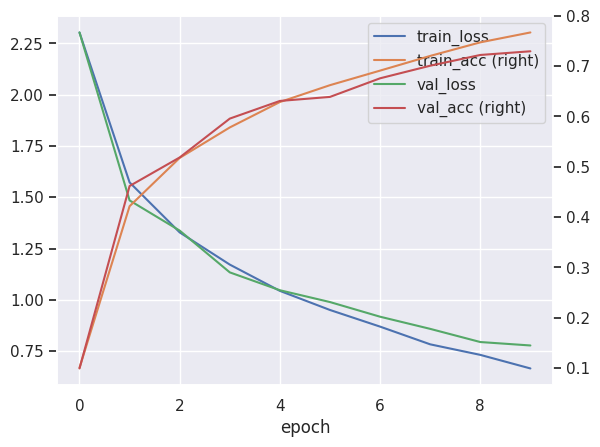

In [28]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

# Další vylepšení

Jako bonus můžete podobně jako ve cvičení [multilayer-perceptron](multilayer-perceptron.ipynb) opět zkusit trochu vylepšit skóre sítě. Implementujte postupně následující kroky, opakujte hlavní cyklus znovu a sledujte, zda a jak se mění výsledná přesnost na validační sadě (`val_acc`). Model by měl na konci snažení dosáhnout **alespoň 90% přesnosti** na validační množině.

## Datová augmentace

Jedním z problémů silnějších modelů se na jednodušších datasetech jako CIFAR10 může stát přeučení. Nejlepším řešením je v takovém případě nasbírat dodatečná data, což však mnohdy boužel není možné. Jako substituci ale můžeme vyzkoušet tzv. [datovou augmentaci](https://d2l.ai/chapter_computer-vision/image-augmentation.html#image-augmentation), která spočívá v umělém rozšířování datasetu pomocí náhodných transformací omezeného množství dat, která máme k dispozici.

**Doporučené augmentace**

V případě obrázků můžeme např. náhodně s pravěpodobností 50 % před vstupem do sítě obrázek horizontálně převrátit, jelikož všechny třídy v datasetu CIFAR10 jsou v tomto symetrické. Stejnou operaci bychom samozřejmě nemohli provádět např. pro číslovky datasetu MNIST. Další vhodnou náhodnou transformací pak může být např. náhodný ořez tak, aby se objekty tříd síti prezentovaly různě velké a také ne pouze uprostřed obrázku.

**Implementace**

Datovou augmentaci aplikujte pouze na trénovací data a to ještě před původním preprocessingem, který musí zůstat pro obě podmnožiny shodný. Použijte k tomu vhodné třídy dostupné v modulu `torchvision.transforms` a přidejte jejich instance na začátek pole `transform`, které vstupuje jako argument do `CIFAR10.__init__`.

### TODO: přidejte do trénovací množiny libovolnou datovou augmentaci

In [45]:
train_dataset_aug = torchvision.datasets.CIFAR10(
    root = '../data',
    train = True,
    transform = torchvision.transforms.Compose([
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    download = True
)
train_dataset_aug

Files already downloaded and verified


Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )

In [48]:
test_convolutional_network.TestAugmentation.eval(train_dataset=train_dataset_aug, val_dataset=val_dataset)

test_train_dataset (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_train_dataset) ... ok
test_val_dataset (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_val_dataset) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.064s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [52]:
%%time

# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 30
batch_size = 1024
learning_rate = 1e-3
momentum = .85
weight_decay = 1e-5
device = 'cuda'  # set to 'cuda' to run on the GPU

train_loader = ans.data.DataLoader(
    train_dataset_aug,  # use augmented dataset
    device = device,
    batch_size = batch_size,
    shuffle = True
)
val_loader = ans.data.DataLoader(
    val_dataset,
    device = device,
    batch_size = batch_size,
    shuffle = False
)

# init parameters
model = VGG7(10)
model.to(device=device)

# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer
optimizer = ans.optim.Adam(model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    gc.collect()
    
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        2.302653   0.099988  2.302693  0.100257
1        2.203878   0.154296  1.874388  0.322236
2        2.033419   0.231646  1.665538  0.387474
3        1.871028   0.298582  1.544948  0.422423
4        1.735063   0.353720  1.478985  0.451230
5        1.624431   0.399227  1.424084  0.476529
6        1.539848   0.434458  1.372997  0.501684
7        1.470791   0.462752  1.353252  0.503673


KeyboardInterrupt: 

train_loss    0.665814
train_acc     0.766771
val_loss      0.777751
val_acc       0.729331
Name: 9, dtype: float64


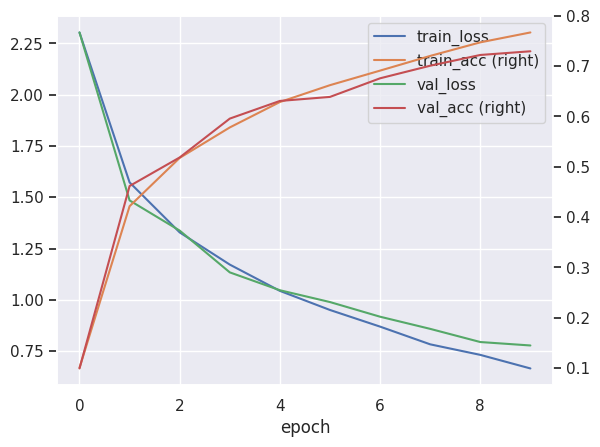

In [32]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Batch normalizace pro 2D vstupy

Pokud máte v knihovně `ans` implementovanou normalizaci dávky pro 1D vstupy z minulého cvičení, můžete ji poměrně jednoduše rozšířit pro 2D vstupy.  Tzv. spatial batchonrm, jak se často 2D varianta normalizace dávky označuje v anglické literatuře, *normalizuje přes jednotlivé kanály vstupu*. To znamená, že vektory $\boldsymbol{\mu}, \boldsymbol{\sigma^2}, \boldsymbol{\gamma}, \boldsymbol{\beta}, \boldsymbol{m}, \boldsymbol{v}^2$ jsou vektory o rozměru $C$. Operaci lze naimplementovat následovně:

1. převedení vstupního tensoru $\boldsymbol{x}$ s rozměry $N \times C \times H \times W$ na 2D matici $(N \cdot H \cdot W) \times C$,
2. aplikace 1D batch normalizace
3. převedení výstupní matice $(N \cdot H \cdot W) \times C$ zpět do tensoru s rozměry $N \times C \times H \times W$.

*Pozor*: převedení tam i zpět nejsou pouhá přetvarování pomocí `reshape`.

**Funkce `BatchNorm2d`**

Jako funkce by 
- `BatchNorm2d.forward` měla volat `BatchNorm1d.forward` se správně upravenými vstupy,
- `BatchNorm2d.backward` měla volat `BatchNorm1d.backward`  se správně upravenými vstupy.

**Vrstva `BatchNorm2d`**

Jako vrstva typu `ans.modules.Module` bude mít `BatchNorm2d`
- metodu `__init__` shodnou s `BatchNorm1d`, takže ji není nutné implementovat
- v metodě `forward` bude volat `ans.functional.BatchNorm2d.apply`

### TODO: implementujte funkci `ans.functional.BatchNorm2d` a modul `ans.modules.BatchNorm2d`

In [55]:
ans.autograd.gradcheck(
    ans.functional.BatchNorm2d.apply,
    (
        randn_var(3, 4, 5, 8, mean=1., std=2., name='input'),
        randn_var(4, name='gamma'),
        randn_var(4, name='beta')
    ),
    params=dict(training=True)
)

dinput ok: rel_err=2.142e-05, abs_err=3.208e-07
dgamma ok: rel_err=3.208e-14, abs_err=2.132e-13
dbeta ok: rel_err=4.718e-15, abs_err=1.954e-14


True

In [56]:
test_convolutional_network.TestBatchNorm2d.eval()

test_forward_function_affine (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_affine) ... ok
test_forward_function_linear (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_function_linear) ... ok
test_forward_module (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward_module) ... ok
test_gradcheck (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_gradcheck) ... ok
test_implementation (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_implementation) ... ok
test_output_types (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_output_types) ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.783s

OK


<unittest.runner.TextTestResult run=6 errors=0 failures=0>

### Konvoluční síť s batch normalizací VGG7BN

Batch normalizaci přidáme do modelu VGG7 a výslednou architekturu označíme jako VGG7BN. Zároveň také vypneme u konvolučních vrstev bias, protože jeho efekt by byl stejně ihned následující normalizací opět odečten. Stejným značením jako u VGG7 architektura bude vypadat následovně:

`CNR(64), M(2), CNR(128), M(2), CNR(256), M(2), CNR(512), M(2), CNR(512), M(2), LR(512), L(10)`

kde:
- `N` značí batch normalizaci

Architektura je tedy shodná s VGG7, pouze místo bloků konvoluce-relu (`CR`) se opakují bloky konvoluce-normalizace-relu (`CNR`).

### TODO: implementujte model `VGG7BN` využívající 2D batch normalizaci

In [57]:
class VGG7BN(ans.modules.Module):

    def __init__(self, num_classes: int, bias: bool = False) -> None:
        super().__init__()

        ########################################
        # TODO: implement

        self.layer1 = ans.modules.Sequential(
            ans.modules.Conv2d(3,64,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(64),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer2 = ans.modules.Sequential(
            ans.modules.Conv2d(64,128,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(128),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer3 = ans.modules.Sequential(
            ans.modules.Conv2d(128,256,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(256),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer4 = ans.modules.Sequential(
            ans.modules.Conv2d(256,512,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(512),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer5 = ans.modules.Sequential(
            ans.modules.Conv2d(512,512,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(512),
            ans.modules.ReLU(),
            ans.modules.MaxPool2d(2))

        self.layer6 = ans.modules.Sequential(
            ans.modules.Flatten(),
            ans.modules.Linear(512,512),
            ans.modules.ReLU(),
            ans.modules.Linear(512,num_classes)
        )

        # ENDTODO
        ########################################
    
    # feel free to add auxiliary methods here
    # def my_function(...)
    
    def forward(self, x: ans.autograd.Variable) -> ans.autograd.Variable:
        ########################################
        # TODO: implement

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        
        return x
        # ENDTODO
        ########################################

In [58]:
test_convolutional_network.TestVGG7BN.eval(model_cls=VGG7BN)

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_num_params (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_num_params) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.270s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [60]:
%%time

# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 30
batch_size = 1024 # mam hodne vram
learning_rate = 1e-3
momentum = .85
weight_decay = 1e-5
device = 'cuda'  # set to 'cuda' to run on the GPU

# data loaders
train_loader = ans.data.DataLoader(
    train_dataset_aug,  # use augmented dataset
    device = device,
    batch_size = batch_size,
    shuffle = True
)
val_loader = ans.data.DataLoader(
    val_dataset,
    device = device,
    batch_size = batch_size,
    shuffle = False
)

# init parameters
model = VGG7BN(10)
model.to(device=device)

# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer
optimizer = ans.optim.Adam(model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    gc.collect()
    
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        2.370500   0.098609  2.373125  0.097846
1        1.998033   0.244420  1.157908  0.576279
2        1.583503   0.408243  1.043936  0.641821
3        1.252254   0.537667  0.953087  0.665908
4        1.005173   0.633647  0.693297  0.760842
5        0.817363   0.704464  0.782764  0.738929
6        0.679088   0.757106  1.024589  0.677954
7        0.573534   0.796528  0.700673  0.773384
8        0.484037   0.829472  0.696700  0.774719
9        0.410550   0.856056  0.882132  0.731075
10       0.351701   0.877140  0.565747  0.820643
11       0.298442   0.895953  0.676281  0.801594
12       0.257632   0.910408  0.816518  0.779514
13       0.221323   0.922978  0.655974  0.815782
14       0.188995   0.934901  0.678151  0.814469
15       0.162406   0.944527  0.721320  0.811159
16       0.141280   0.951573  0.853868  0.792086
17       0.124108   0.957313  1.392647  0.723216
18       0.113376   

KeyboardInterrupt: 

train_loss    0.351701
train_acc     0.877140
val_loss      0.565747
val_acc       0.820643
Name: 10, dtype: float64


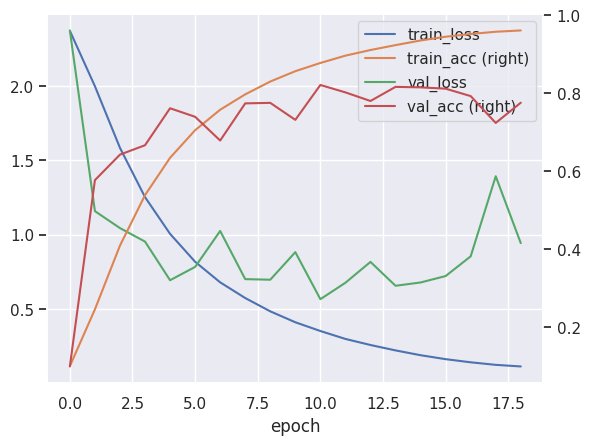

In [61]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);

## Residuální sítě ResNet

Jako poslední vylepšení můžete zkusit použít residuální bloky, které tvoří základ sítí ResNet. Např. v benchmarku [DAWNBBench](https://dawn.cs.stanford.edu/benchmark/CIFAR10/train.html), kde se kromě jiného hodnotí i rychlost trénování, se na předních pro dataset CIFAR-10 umisťuje varianta ResNet9. Architektura není standardizovaná a publikovaná, byla objevena komunitou a mezi jednotlivými implementacemi se liší. Vyzkoušíme její původní variantu ze série příspěvků o optimalizaci trénování ResNetu na datasetu CIFAR-10 na adrese https://myrtle.ai/learn/how-to-train-your-resnet/.

Shodným značením s VGG7 a VGG7BN má model Resnet9 následující architekturu:

`CNR(64), CNR(128), M(2), res(CNR(128), CNR(128)), CNR(256), M(2), CNR(512), M(2), res(CNR(512), CNR(512)), M(4), L(10)`

kde:
- `res(convblock)` značí residuální blok formy `z = x + convblock(x)`

### TODO: implementujte model ResNet9

In [62]:
class ResNet9(ans.modules.Module):

    def __init__(self, num_classes: int, bias: bool = False) -> None:
        super().__init__()

        ########################################
        # TODO: implement
        self.max_pool2 = ans.modules.MaxPool2d(window_size=2)
        self.max_pool4 = ans.modules.MaxPool2d(window_size=4)

        self.layer3_64 = ans.modules.Sequential(
            ans.modules.Conv2d(3,64,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(64),
            ans.modules.ReLU())

        self.layer64_128 = ans.modules.Sequential(
            ans.modules.Conv2d(64,128,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(128),
            ans.modules.ReLU())

        self.layer128_128_res_1 = ans.modules.Sequential(
            ans.modules.Conv2d(128,128,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(128),
            ans.modules.ReLU())

        self.layer128_128_res_2 = ans.modules.Sequential(
            ans.modules.Conv2d(128,128,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(128),
            ans.modules.ReLU())

        self.layer128_256 = ans.modules.Sequential(
            ans.modules.Conv2d(128,256,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(256),
            ans.modules.ReLU())

        self.layer256_512 = ans.modules.Sequential(
            ans.modules.Conv2d(256,512,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(512),
            ans.modules.ReLU())

        self.layer512_512_res_2 = ans.modules.Sequential(
            ans.modules.Conv2d(512,512,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(512),
            ans.modules.ReLU())

        self.layer512_512_res_1 = ans.modules.Sequential(
            ans.modules.Conv2d(512,512,kernel_size=3,padding=1,stride=1,bias=bias),
            ans.modules.BatchNorm2d(512),
            ans.modules.ReLU())

        self.layer_lin = ans.modules.Sequential(
            ans.modules.Flatten(),
            ans.modules.Linear(512,num_classes)
        )

        # ENDTODO
        ########################################

    # feel free to add auxiliary methods here
    # def my_function(...)

    def forward(self, x: ans.autograd.Variable) -> ans.autograd.Variable:
        ########################################
        # TODO: implement

        x = self.layer3_64(x)
        x = self.layer64_128(x)
        x = self.max_pool2(x)

        res = x
        x = self.layer128_128_res_1(x)
        x = self.layer128_128_res_2(x)
        x = x + res

        x = self.layer128_256(x)
        x = self.max_pool2(x)
        x = self.layer256_512(x)
        x = self.max_pool2(x)

        res = x
        x = self.layer512_512_res_1(x)
        x = self.layer512_512_res_2(x)
        x = x + res

        x = self.max_pool4(x)
        x = self.layer_lin(x)

        return x

        # ENDTODO
        ########################################

In [63]:
test_convolutional_network.TestResnet9.eval(model_cls=ResNet9)

test_forward (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_forward) ... ok
test_num_params (tests.ANSTestCase.eval.<locals>._TestCaseClass.test_num_params) ... ok

----------------------------------------------------------------------
Ran 2 tests in 0.440s

OK


<unittest.runner.TextTestResult run=2 errors=0 failures=0>

In [67]:
%%time

# reproducibility
ans.utils.seed_everything(0)

# hyperparameters
num_epochs = 30
batch_size = 256
learning_rate = 5e-4
momentum = .9
weight_decay = 1e-5
device = 'cuda'  # set to 'cuda' to run on the GPU

# data loaders
train_loader = ans.data.DataLoader(
    train_dataset_aug,  # use augmented dataset
    device = device,
    batch_size = batch_size,
    shuffle = True
)
val_loader = ans.data.DataLoader(
    val_dataset,
    device = device,
    batch_size = batch_size,
    shuffle = False
)

# init parameters
model = ResNet9(10)
model.to(device=device)

# loss function
criterion = ans.modules.SoftmaxCrossEntropy()

# optimizer
optimizer = ans.optim.Adam(model.parameters(), learning_rate=learning_rate, weight_decay=weight_decay)

# validate once before training
train_loss, train_acc = validate(train_loader, model, criterion)
val_loss, val_acc = validate(val_loader, model, criterion)

# record history for plotting
history = ans.utils.MetricsHistory()
history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

# optimize
for epoch in range(num_epochs):
    gc.collect()
    
    # train loop
    model.train()
    for inputs, targets in train_loader:
        loss, acc = train_step(inputs, targets, model, criterion, optimizer)
        train_loss = 0.99 * train_loss + 0.01 * loss
        train_acc = 0.99 * train_acc + 0.01 * acc
    
    # validation loop
    model.eval()
    val_loss, val_acc = validate(val_loader, model, criterion)
    
    history.update(train_loss=train_loss, train_acc=train_acc, val_loss=val_loss, val_acc=val_acc)

       train_loss  train_acc  val_loss   val_acc
epoch                                           
0        3.626160   0.099470  3.648030  0.096680
1        1.333167   0.582945  0.930496  0.679785
2        0.715940   0.758035  0.623738  0.779590
3        0.497505   0.829632  0.534023  0.814453
4        0.386780   0.869189  0.537482  0.814941
5        0.315594   0.892701  0.519220  0.829004
6        0.263785   0.911186  0.454540  0.844238
7        0.201435   0.932416  0.492079  0.842871
8        0.168564   0.944148  0.566505  0.818750
9        0.134286   0.957147  0.580443  0.829004
10       0.099719   0.969290  0.510639  0.846680
11       0.084159   0.973891  0.472856  0.861230
12       0.064137   0.981126  0.685307  0.817578
13       0.062779   0.981633  0.426255  0.871875
14       0.053662   0.983794  0.495979  0.860156
15       0.048761   0.985008  0.522273  0.855371
16       0.034583   0.990349  0.546026  0.858203
17       0.031057   0.991144  0.510989  0.857422
18       0.037994   

train_loss    0.015932
train_acc     0.995845
val_loss      0.400012
val_acc       0.891113
Name: 22, dtype: float64


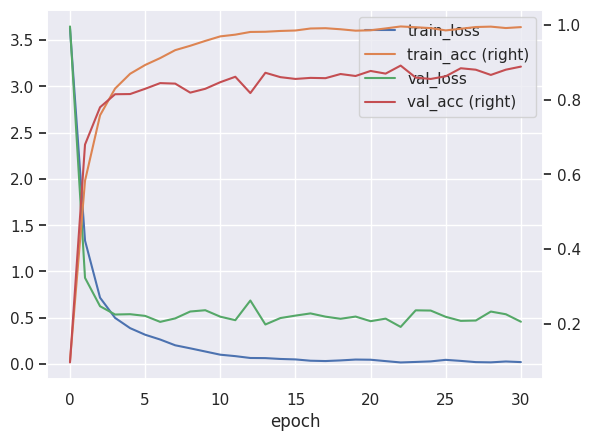

In [68]:
print(history.best_results('val_acc', 'max'))
history.df().plot(secondary_y=['train_acc', 'val_acc']);